
# Exercise 2

In [7]:
import tensorflow as tf
from autograd import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [2]:
train_labels.shape=(1,60000)
test_labels.shape=(1,10000)
train_images=(train_images.reshape(60000,784)).T
test_images=(test_images.reshape(10000,784)).T
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(train_images.dtype)
print(train_labels.dtype)

(784, 60000)
(784, 10000)
(1, 60000)
(1, 10000)
uint8
uint8


In [3]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# multiclass perceptron
def multiclass_perceptron(w,x,y,iter):
    # get subset of points
    x_p = x[:,iter]
    y_p = y[:,iter]

    # pre-compute predictions on all points
    all_evals = model(x_p,w)

    # compute maximum across data points
    a =  np.max(all_evals,axis = 0)        

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y_p.astype(int).flatten(),np.arange(np.size(y_p))]
    cost = np.sum(a - b)

    # return average
    return cost/float(np.size(y_p))

#### 2.1

In [4]:
from autograd.misc.flatten import flatten_func
from autograd import grad 

# minibatch gradient descent
def minibatch_gradient_descent(g,w,x_train,y_train,alpha,max_its,batch_size):    
    #Initialize weight container and cost history container
    num_samples=np.size(y_train)
    weight_history=[w]
    cost_history=[g(w,x_train,y_train,range(0,num_samples,1))] #Cost is computed for entire dataset
    
    for k in range(max_its):
        print('Now starting Epoch: '+str(k+1)+'/'+str(max_its))
        for i in range(0,num_samples,batch_size):
            g_batch = lambda w: g(w,x_train,y_train,range(i,i+batch_size,1)) 
            #Set g_batch to be gradient w.r.t current batch
            if(i+batch_size>num_samples):
                #If number of samples not divisible by the batch size, then for the last set subset only until final element
                g_batch = lambda w: g(w,x_train,y_train,range(i,num_samples-1))
            
            gradient = grad(g_batch)
            # evaluate the gradient
            grad_eval = gradient(w)
            # take gradient descent step
            w = w - alpha*grad_eval                
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w,x_train,y_train,range(0,num_samples)))
    return weight_history,cost_history

#### 2.2

In [5]:
C = np.size(np.unique(train_labels))
N = train_images.shape[0]
P = np.size(train_labels)
w = 0.1*np.random.randn(N+1,C)

In [6]:
w = 0.1*np.random.randn(N+1,C)
weight_history_200,cost_history_200 = minibatch_gradient_descent(multiclass_perceptron,w,train_images,
                                                         train_labels,0.001,5,200)

Now starting Epoch: 1/5
Now starting Epoch: 2/5
Now starting Epoch: 3/5
Now starting Epoch: 4/5
Now starting Epoch: 5/5


In [7]:
weight_history_full,cost_history_full= minibatch_gradient_descent(multiclass_perceptron,w,train_images,
                                                         train_labels,0.001,5,P)

Now starting Epoch: 1/5
Now starting Epoch: 2/5
Now starting Epoch: 3/5
Now starting Epoch: 4/5
Now starting Epoch: 5/5


# Exercise 3

In [8]:
datapath = 'Data/'

In [9]:
def model(x,C):  
    w = np.matmul(C.T,x)
    return w
def autoencoder(C):
    decoded_x = np.matmul(C,model(x,C))
    cost = np.sum((decoded_x-x)**2)/x.shape[1]
    return cost

In [10]:
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w]     # container for weight history
    cost_history = [g(w)]    # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval

        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

In [11]:
x = np.loadtxt(datapath + '2d_span_data_centered.csv',delimiter=',')
C = np.array([[-3.5],[3.5]])
g = autoencoder; alpha_choice = 10**(-4); max_its = 1000; C = 0.1*np.random.randn(2,1);


In [12]:
C_history,cost_history=gradient_descent(g,alpha_choice,max_its,C)

In [13]:
best_C = C_history[np.argmin(cost_history)]
encoded_x = model(x,best_C)
decoded_x = np.matmul(C,encoded_x)

In [14]:
best_C

array([[ 0.63359213],
       [-0.76797711]])

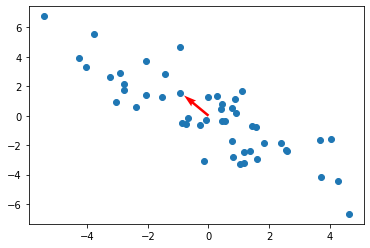

In [15]:
plt.scatter(x[0],x[1])
origin = np.array([[0],[0]]) # origin point
plt.quiver(*origin, best_C[1]*2, best_C[0]*2, color='r', scale=21)
plt.show()

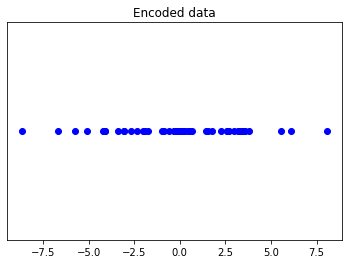

In [16]:

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(encoded_x, np.zeros_like(encoded_x) + val,'o',c='b')
plt.tick_params(left=False,labelleft=False)
plt.title('Encoded data')
plt.show()

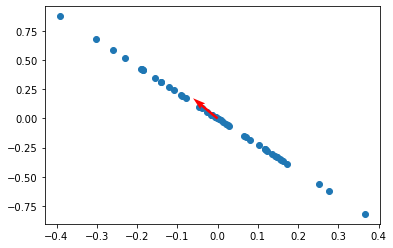

In [17]:
plt.scatter(decoded_x[0],decoded_x[1])
origin = np.array([[0],[0]]) # origin point
plt.quiver(*origin, best_C[1]*2, best_C[0]*2, color='r', scale=21)
plt.show()

# Exercise 4

In [18]:
def center(X):
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means

    return X_normalized

def compute_pcs(X,lam):
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    D,V = np.linalg.eigh(Cov)
    return D,V

In [19]:
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')
X_centered = center(X_original)
D,V=compute_pcs(X_centered,10e-5)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc = {'figure.figsize':(12,8)}) #Seaborn settings for plotting
sns.set_style("darkgrid")

In [85]:
X_centered.shape

(2, 50)

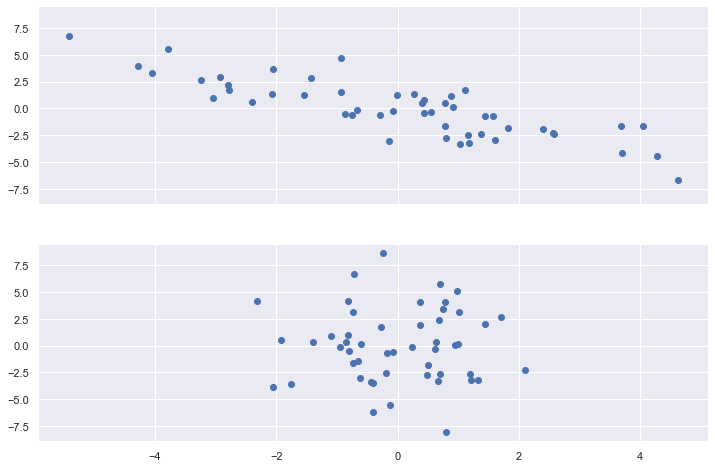

In [86]:
fig,axs=plt.subplots(2,sharex=True,sharey=True)
axs[0].scatter(X_centered[0],X_centered[1])
projected = np.dot(V.T,X_centered)
axs[1].scatter(projected[0],projected[1])

# Exercise 5

In [87]:
def update_assignments(data,centroids):
    assignments = []
    for i in data.T:
        assignment = np.argmin(np.sum((centroids - i)**2,axis=1))
        assignments.append(assignment)
    return np.array(assignments)
        
def update_centroids(data,old_centroids,assignments):
    new_centroids = []
    for i in range(len(old_centroids)):
        points = data[:,np.where(assignments==i)]
        new_centroid = np.mean(data[:,np.where(assignments==i)[0]],axis=1)
        new_centroids.append(new_centroid)
    return np.array(new_centroids)



In [88]:
data = np.loadtxt(datapath+'blobs.dat')

In [89]:
K = 3
no_its = 5
centroids = np.array([[-8,4],[0,4],[-3,-1]])
assignments = update_assignments(data,centroids)
centroid_history = [centroids]
for i in range(no_its):
    centroids = update_centroids(data,centroids,assignments)
    assignments = update_assignments(data,centroids)
    centroid_history.append(centroids)

In [90]:
for K in range(1,11):
    centroids = np.array([[-8,4],[0,4],[-3,-1]])
    assignments = update_assignments(data,centroids)
    for i in range(no_its):
        centroids = update_centroids(data,centroids,assignments)
        assignments = update_assignments(data,centroids)
    

C:\Users\nicho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nicho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

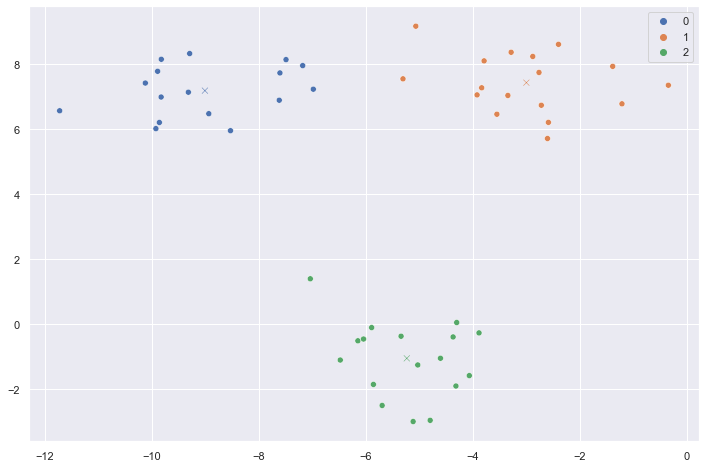

In [91]:
sns.scatterplot(data[0],data[1],hue=assignments.astype(str))
sns.scatterplot(centroids[:,0],centroids[:,1],hue=np.array(['0','1','2']),marker='x',legend=False)

# Exercise 6

In [1]:
import numpy as np
from urllib.request import urlopen
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
raw_data = urlopen(url)
dataset = np.loadtxt(raw_data, delimiter=",")
print(dataset.shape)

(1372, 5)


In [3]:
X=dataset[:,[1,3]]
Y=dataset[:,4]
print(X.shape)
print(Y.shape)

(1372, 2)
(1372,)


C:\Users\nicho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

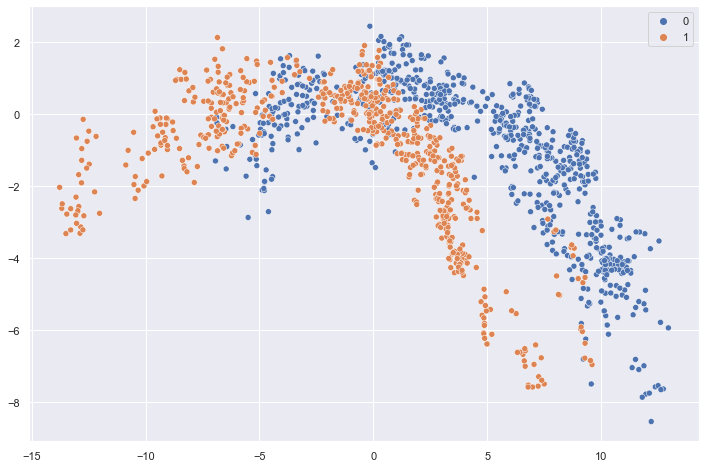

In [4]:
sns.scatterplot(X[:,0],X[:,1],hue=Y.astype(int).astype(str))

In [5]:
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow import keras

opt = tf.keras.optimizers.SGD(learning_rate=0.15)
model = keras.Sequential()
model.add(Dense(1, batch_input_shape=(None, 2),activation='sigmoid'))
model.compile(opt,loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit(X,Y,batch_size=128,epochs=400)


Epoch 1/400
11/11 [==============================] - 1s 1ms/step - loss: 0.9234 - accuracy: 0.5742
Epoch 2/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5832 - accuracy: 0.6571
Epoch 3/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5235 - accuracy: 0.7273
Epoch 4/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5191 - accuracy: 0.7287
Epoch 5/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5267 - accuracy: 0.7255
Epoch 6/400
11/11 [==============================] - 0s 997us/step - loss: 0.5054 - accuracy: 0.7403
Epoch 7/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5181 - accuracy: 0.7238
Epoch 8/400
11/11 [==============================] - 0s 998us/step - loss: 0.5084 - accuracy: 0.7219
Epoch 9/400
11/11 [==============================] - 0s 997us/step - loss: 0.5023 - accuracy: 0.7292
Epoch 10/400
11/11 [==============================] - 0s 995us/step - loss: 0.5061 - accuracy: 0.7114
E

11/11 [==============================] - 0s 798us/step - loss: 0.5004 - accuracy: 0.7189
Epoch 81/400
11/11 [==============================] - 0s 791us/step - loss: 0.5086 - accuracy: 0.7163
Epoch 82/400
11/11 [==============================] - 0s 804us/step - loss: 0.5289 - accuracy: 0.6950
Epoch 83/400
11/11 [==============================] - 0s 907us/step - loss: 0.5142 - accuracy: 0.7090
Epoch 84/400
11/11 [==============================] - 0s 997us/step - loss: 0.5120 - accuracy: 0.6989
Epoch 85/400
11/11 [==============================] - 0s 986us/step - loss: 0.5138 - accuracy: 0.7113
Epoch 86/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5117 - accuracy: 0.7045
Epoch 87/400
11/11 [==============================] - 0s 997us/step - loss: 0.5097 - accuracy: 0.7212
Epoch 88/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5197 - accuracy: 0.7067
Epoch 89/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5061 - accuracy: 0.7168

11/11 [==============================] - 0s 898us/step - loss: 0.5069 - accuracy: 0.7080
Epoch 161/400
11/11 [==============================] - 0s 997us/step - loss: 0.5259 - accuracy: 0.6994
Epoch 162/400
11/11 [==============================] - 0s 895us/step - loss: 0.5189 - accuracy: 0.7117
Epoch 163/400
11/11 [==============================] - 0s 901us/step - loss: 0.5178 - accuracy: 0.7024
Epoch 164/400
11/11 [==============================] - ETA: 0s - loss: 0.5431 - accuracy: 0.68 - 0s 798us/step - loss: 0.5113 - accuracy: 0.7094
Epoch 165/400
11/11 [==============================] - 0s 798us/step - loss: 0.5241 - accuracy: 0.6979
Epoch 166/400
11/11 [==============================] - 0s 830us/step - loss: 0.5265 - accuracy: 0.6990
Epoch 167/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5179 - accuracy: 0.7093
Epoch 168/400
11/11 [==============================] - 0s 959us/step - loss: 0.5125 - accuracy: 0.7114
Epoch 169/400
11/11 [==========================

11/11 [==============================] - 0s 997us/step - loss: 0.5285 - accuracy: 0.6917
Epoch 240/400
11/11 [==============================] - 0s 997us/step - loss: 0.5007 - accuracy: 0.7198
Epoch 241/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5202 - accuracy: 0.6996
Epoch 242/400
11/11 [==============================] - 0s 872us/step - loss: 0.5155 - accuracy: 0.7036
Epoch 243/400
11/11 [==============================] - 0s 898us/step - loss: 0.5202 - accuracy: 0.6934
Epoch 244/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5095 - accuracy: 0.7146
Epoch 245/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5205 - accuracy: 0.7065
Epoch 246/400
11/11 [==============================] - 0s 898us/step - loss: 0.5275 - accuracy: 0.7022
Epoch 247/400
11/11 [==============================] - 0s 927us/step - loss: 0.5208 - accuracy: 0.6952
Epoch 248/400
11/11 [==============================] - 0s 901us/step - loss: 0.5145 - accurac

11/11 [==============================] - 0s 858us/step - loss: 0.5337 - accuracy: 0.6948
Epoch 320/400
11/11 [==============================] - 0s 898us/step - loss: 0.5162 - accuracy: 0.7073
Epoch 321/400
11/11 [==============================] - 0s 798us/step - loss: 0.5211 - accuracy: 0.7019
Epoch 322/400
11/11 [==============================] - 0s 897us/step - loss: 0.5262 - accuracy: 0.6849
Epoch 323/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5213 - accuracy: 0.7011
Epoch 324/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5135 - accuracy: 0.7121
Epoch 325/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5121 - accuracy: 0.7032
Epoch 326/400
11/11 [==============================] - 0s 1ms/step - loss: 0.5060 - accuracy: 0.7117
Epoch 327/400
11/11 [==============================] - 0s 997us/step - loss: 0.4963 - accuracy: 0.7269
Epoch 328/400
11/11 [==============================] - 0s 1000us/step - loss: 0.5145 - accuracy

11/11 [==============================] - 0s 813us/step - loss: 0.5262 - accuracy: 0.7029
Epoch 399/400
11/11 [==============================] - 0s 798us/step - loss: 0.4993 - accuracy: 0.7236
Epoch 400/400
11/11 [==============================] - 0s 898us/step - loss: 0.5208 - accuracy: 0.7070


In [9]:
historyDF = pd.DataFrame(history.history)
historyDF['epoch']=historyDF.index+1

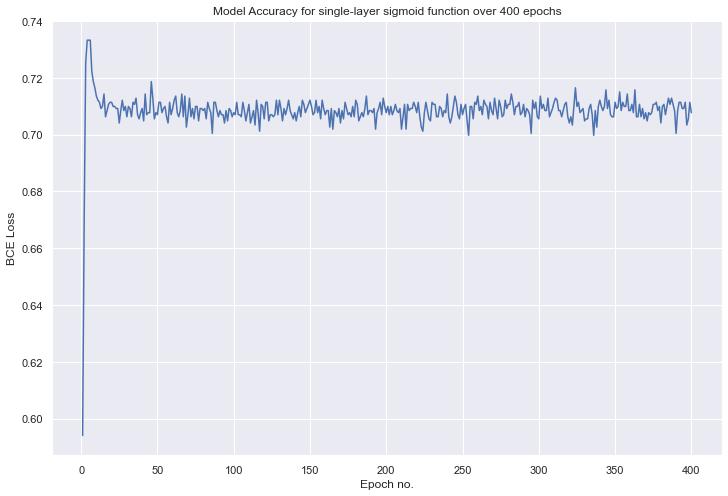

In [10]:
p = sns.lineplot(data=historyDF,y='accuracy',x='epoch')
_=p.set(title="Model Accuracy for single-layer sigmoid function over 400 epochs",ylabel="BCE Loss",xlabel="Epoch no.")

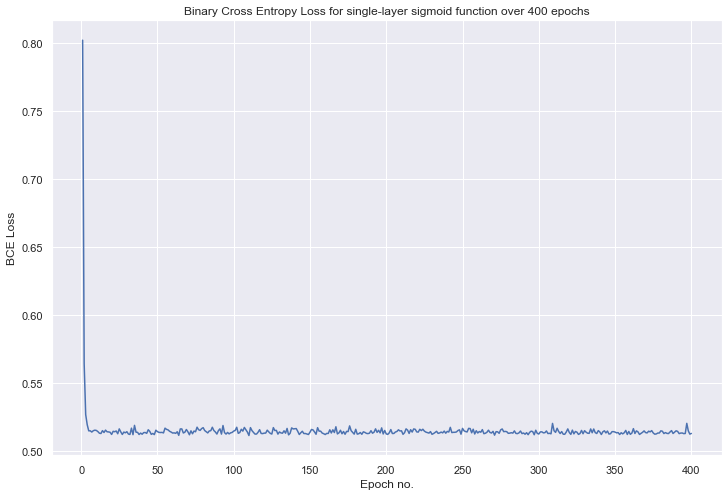

In [11]:
p = sns.lineplot(data=historyDF,y='loss',x='epoch')
_=p.set(title="Binary Cross Entropy Loss for single-layer sigmoid function over 400 epochs",ylabel="BCE Loss",xlabel="Epoch no.")

In [12]:
print('Final Accuracy: ',str(history.history['accuracy'][-1]))

Final Accuracy:  0.7077259421348572


In [105]:
x1list = np.linspace(np.min(X[:,0])-2, np.max(X[:,0])+2, 50) # Define 50 points on the x1-axis
x2list = np.linspace(np.min(X[:,1])-2, np.max(X[:,1])+2, 50) # Define 50 points on the x2-axis

In [106]:
x1s,x2s=np.meshgrid(x1list,x2list)

In [107]:
x1,x2=x1s.flatten(),x2s.flatten()
grid = np.vstack((x1,x2)).T
y_pred = model.predict(grid)
y_preds = y_pred.reshape(x1s.shape)

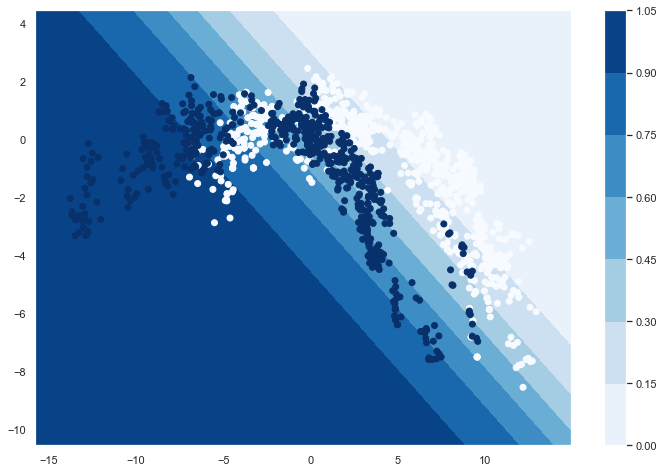

In [108]:
from matplotlib.colors import Colormap
plt.figure()
plt.contourf(x1s,x2s,y_preds,cmap='Blues')
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c=Y,cmap='Blues')


In [109]:
from tensorflow.keras.utils import to_categorical
Y_c=to_categorical(Y,2)

In [111]:
Y_c

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [112]:
opt = tf.keras.optimizers.SGD(learning_rate=0.15)
model = keras.Sequential()
model.add(Dense(8, batch_input_shape=(None, 2),activation='sigmoid'))
model.add(Dense(2,batch_input_shape=(None,8),activation='softmax'))
model.compile(opt,loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(X,Y_c,batch_size=128,epochs=400)


Epoch 1/400
11/11 [==============================] - 9s 4ms/step - loss: 0.7288 - accuracy: 0.4904
Epoch 2/400
11/11 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6298
Epoch 3/400
11/11 [==============================] - 0s 4ms/step - loss: 0.5650 - accuracy: 0.6968
Epoch 4/400
11/11 [==============================] - 0s 4ms/step - loss: 0.5331 - accuracy: 0.6945
Epoch 5/400
11/11 [==============================] - 0s 3ms/step - loss: 0.5040 - accuracy: 0.7308
Epoch 6/400
11/11 [==============================] - 0s 4ms/step - loss: 0.4942 - accuracy: 0.7293
Epoch 7/400
11/11 [==============================] - 0s 3ms/step - loss: 0.4930 - accuracy: 0.7365
Epoch 8/400
11/11 [==============================] - 0s 2ms/step - loss: 0.4942 - accuracy: 0.7405
Epoch 9/400
11/11 [==============================] - 0s 2ms/step - loss: 0.4861 - accuracy: 0.7480
Epoch 10/400
11/11 [==============================] - 0s 2ms/step - loss: 0.4855 - accuracy: 0.7512
Epoch 11/

11/11 [==============================] - 0s 3ms/step - loss: 0.3774 - accuracy: 0.8170
Epoch 83/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3716 - accuracy: 0.8260
Epoch 84/400
11/11 [==============================] - 0s 3ms/step - loss: 0.3781 - accuracy: 0.8141
Epoch 85/400
11/11 [==============================] - 0s 3ms/step - loss: 0.3770 - accuracy: 0.8097
Epoch 86/400
11/11 [==============================] - 0s 3ms/step - loss: 0.3562 - accuracy: 0.8274
Epoch 87/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3756 - accuracy: 0.8188
Epoch 88/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3619 - accuracy: 0.8330
Epoch 89/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3683 - accuracy: 0.8228
Epoch 90/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3676 - accuracy: 0.8154
Epoch 91/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3646 - accuracy: 0.8283
Epoch 92/400


11/11 [==============================] - 0s 3ms/step - loss: 0.3487 - accuracy: 0.8296
Epoch 164/400
11/11 [==============================] - 0s 3ms/step - loss: 0.3465 - accuracy: 0.8261
Epoch 165/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3391 - accuracy: 0.8324
Epoch 166/400
11/11 [==============================] - 0s 3ms/step - loss: 0.3496 - accuracy: 0.8257
Epoch 167/400
11/11 [==============================] - 0s 3ms/step - loss: 0.3409 - accuracy: 0.8323
Epoch 168/400
11/11 [==============================] - 0s 3ms/step - loss: 0.3590 - accuracy: 0.8173
Epoch 169/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.8287
Epoch 170/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3420 - accuracy: 0.8218
Epoch 171/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3373 - accuracy: 0.8332
Epoch 172/400
11/11 [==============================] - 0s 4ms/step - loss: 0.3387 - accuracy: 0.8364
Epoc

11/11 [==============================] - 0s 2ms/step - loss: 0.3060 - accuracy: 0.8564
Epoch 245/400
11/11 [==============================] - 0s 2ms/step - loss: 0.2919 - accuracy: 0.8730
Epoch 246/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3115 - accuracy: 0.8573
Epoch 247/400
11/11 [==============================] - 0s 2ms/step - loss: 0.2953 - accuracy: 0.8609
Epoch 248/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3126 - accuracy: 0.8574
Epoch 249/400
11/11 [==============================] - 0s 3ms/step - loss: 0.3035 - accuracy: 0.8651
Epoch 250/400
11/11 [==============================] - 0s 4ms/step - loss: 0.3016 - accuracy: 0.8587
Epoch 251/400
11/11 [==============================] - 0s 4ms/step - loss: 0.2990 - accuracy: 0.8636
Epoch 252/400
11/11 [==============================] - 0s 4ms/step - loss: 0.3073 - accuracy: 0.8612
Epoch 253/400
11/11 [==============================] - 0s 4ms/step - loss: 0.3066 - accuracy: 0.8552
Epoc

11/11 [==============================] - 0s 2ms/step - loss: 0.2686 - accuracy: 0.8772
Epoch 326/400
11/11 [==============================] - 0s 2ms/step - loss: 0.2845 - accuracy: 0.8727
Epoch 327/400
11/11 [==============================] - 0s 2ms/step - loss: 0.2821 - accuracy: 0.8780
Epoch 328/400
11/11 [==============================] - 0s 2ms/step - loss: 0.2873 - accuracy: 0.8690
Epoch 329/400
11/11 [==============================] - 0s 2ms/step - loss: 0.2722 - accuracy: 0.8765
Epoch 330/400
11/11 [==============================] - 0s 2ms/step - loss: 0.2840 - accuracy: 0.8718
Epoch 331/400
11/11 [==============================] - 0s 2ms/step - loss: 0.2916 - accuracy: 0.8655
Epoch 332/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3037 - accuracy: 0.8667
Epoch 333/400
11/11 [==============================] - 0s 2ms/step - loss: 0.3010 - accuracy: 0.8612
Epoch 334/400
11/11 [==============================] - 0s 2ms/step - loss: 0.2829 - accuracy: 0.8672
Epoc

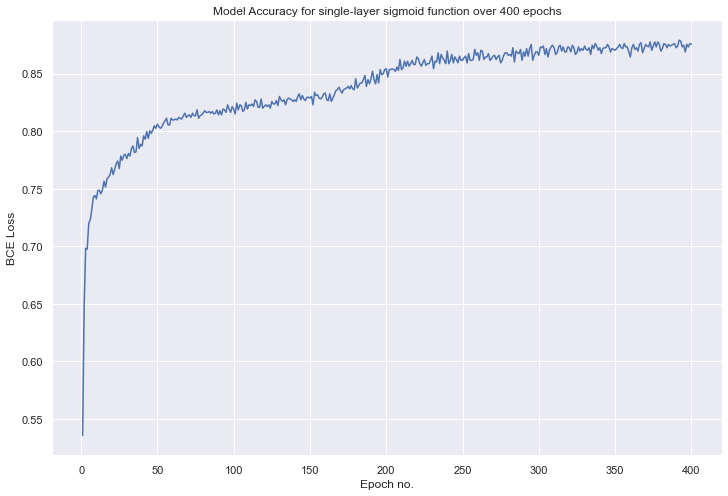

In [113]:
historyDF = pd.DataFrame(history.history)
historyDF['epoch']=historyDF.index+1
p = sns.lineplot(data=historyDF,y='accuracy',x='epoch')
_=p.set(title="Model Accuracy for single-layer sigmoid function over 400 epochs",ylabel="BCE Loss",xlabel="Epoch no.")

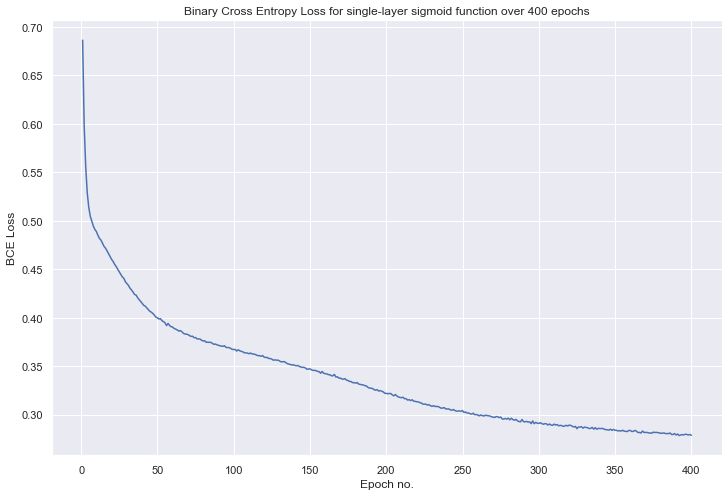

In [114]:
p = sns.lineplot(data=historyDF,y='loss',x='epoch')
_=p.set(title="Binary Cross Entropy Loss for single-layer sigmoid function over 400 epochs",ylabel="BCE Loss",xlabel="Epoch no.")

In [116]:
y_pred

array([[7.2193366e-01, 2.7806634e-01],
       [7.4687415e-01, 2.5312591e-01],
       [7.6472878e-01, 2.3527129e-01],
       ...,
       [9.9947184e-01, 5.2819238e-04],
       [9.9948323e-01, 5.1678531e-04],
       [9.9949300e-01, 5.0698861e-04]], dtype=float32)

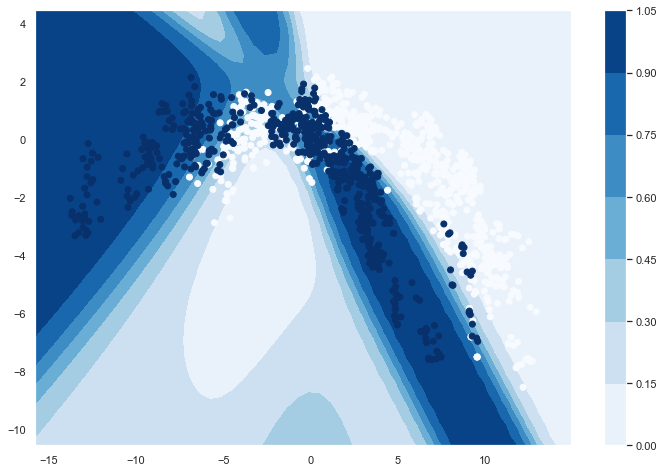

In [117]:
x1list = np.linspace(np.min(X[:,0])-2, np.max(X[:,0])+2, 50) # Define 50 points on the x1-axis
x2list = np.linspace(np.min(X[:,1])-2, np.max(X[:,1])+2, 50) # Define 50 points on the x2-axis

x1s,x2s=np.meshgrid(x1list,x2list)

x1,x2=x1s.flatten(),x2s.flatten()
grid = np.vstack((x1,x2)).T
y_pred = model.predict(grid)
y_preds = y_pred[:,1].reshape(x1s.shape)

from matplotlib.colors import Colormap
plt.figure()
plt.contourf(x1s,x2s,y_preds,cmap='Blues')
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c=Y,cmap='Blues')
